In [363]:
# Import methods
%run Methods.ipynb

In [364]:
# Old LMO
area = np.pi
thickness = 90
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2023\LESK32\SCE_mimic\Full lithiation'
file = [os.path.join(path, i) for i in os.listdir(path)][0]
df1 = pd.read_csv(file, sep = ';')
df1[strings[0]] = df1['WE(1).Current (A)'] / area
df1['CV'] = 'Initial'
df1['Sample'] = 'LMO for NanoSCE 2023'
df1['Corrected Time'] = df1['Time (s)'] - df1['Time (s)'][0]
df1 = df1.rename(columns = {'WE(1).Current (A)' : col_cv[1],
                          'Time (s)' : 'time',
                          'Corrected Time' : 'Time (s)',
                          'WE(1).Potential (V)' : col_cv[0],
                          'WE(1).Charge (C)' : 'Charge (C)'})

In [365]:
###### PLOT Old LMO
dpi = 100
map = 'flare'
# cv_plot(df1, map, dpi)
# capacity_cv(df1, dpi, area, thickness, 3200, 4650, True)
# capacity_cv(df1, dpi, area, thickness, 4730, 6540, True)

In [366]:
# New LMO cv low potentials 1.5V
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_CV'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO lp 1.5V'
std02_lp = cc(path, area, thickness, sample)

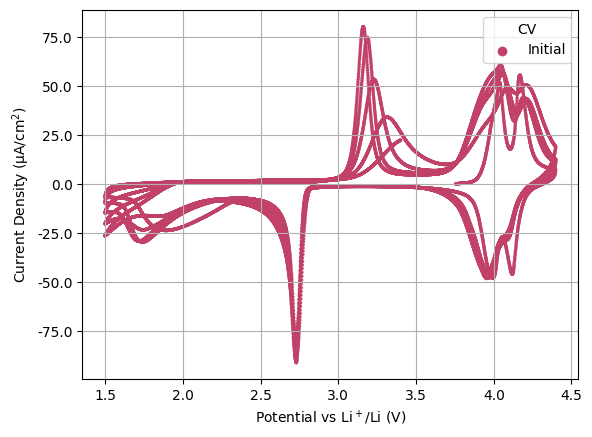

In [367]:
##### PLOT New LMO at low pot 1.5V
cv_plot(std02_lp, map, 100)

# capacity_cv(std02_lp[0], dpi, area, thickness, 0, 604, True)
# capacity_cv(std02_lp[0], dpi, area, thickness, 683, 3320, True)
# capacity_cv(std02_lp[0], dpi, area, thickness, 3450,6020, True)
# capacity_cv(std02_lp[0], dpi, area, thickness, 6150, 8750, True)
# capacity_cv(std02_lp[0], dpi, area, thickness, 9000, 11460, True)
# capacity_cv(std02_lp[0], dpi, area, thickness, 11600, 14180, True)
# capacity_cv(std02_lp[0], dpi, area, thickness, 14550, 16900, True)
# capacity_cv(std02_lp[0], dpi, area, thickness, 17020, 19610, True)
# capacity_cv(std02_lp[0], dpi, area, thickness, 20000, 22320, True)
# capacity_cv(std02_lp[0], dpi, area, thickness, 22480, 25040, True)
# capacity_cv(std02_lp[0], dpi, area, thickness, 25450, 29000, False)


In [369]:
#### LMO/TiO2 9nm
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2023\ALD TiO2\144cycles_ext\1C\CV'
file = [os.path.join(path, i) for i in os.listdir(path)][0]
area = np.pi
thickness = 90
lmo_tio2_9 = pd.read_csv(file, sep = ';')
lmo_tio2_9[strings[0]] = lmo_tio2_9['WE(1).Current (A)'] / area
lmo_tio2_9['CV'] = 'Initial'
lmo_tio2_9['Sample'] = 'LMO/TiO2 9nm'
lmo_tio2_9['Corrected Time'] = lmo_tio2_9['Time (s)'] - lmo_tio2_9['Time (s)'][0]
lmo_tio2_9 = lmo_tio2_9.rename(columns = {'WE(1).Current (A)' : col_cv[1],
                          'Time (s)' : 'time',
                          'Corrected Time' : 'Time (s)',
                          'WE(1).Potential (V)' : col_cv[0],
                          'WE(1).Charge (C)' : 'Charge (C)'})

lmo_tio2_9 = lmo_tio2_9[lmo_tio2_9[col_cv[0]] > 1.25] # removed some outliers

In [370]:
###### PLOT LMO/TiO2 9nm
dpi = 100
map = 'flare'
# cv_plot(lmo_tio2_9, map, dpi)
# capacity_cv(lmo_tio2_9, dpi, area, thickness, 0, 1600, True)
# capacity_cv(lmo_tio2_9, dpi, area, thickness, 2070, 4780, True)
# capacity_cv(lmo_tio2_9, dpi, area, thickness, 5000, 7870, True)
# capacity_cv(lmo_tio2_9, dpi, area, thickness, 8245, 10950, True)
# capacity_cv(lmo_tio2_9, dpi, area, thickness, 11300, 14045, True)
# capacity_cv(lmo_tio2_9, dpi, area, thickness, 14430, 17130, True)
# capacity_cv(lmo_tio2_9, dpi, area, thickness, 14430, 17130, False)

Text(0.5, 1.0, 'Scan 2')

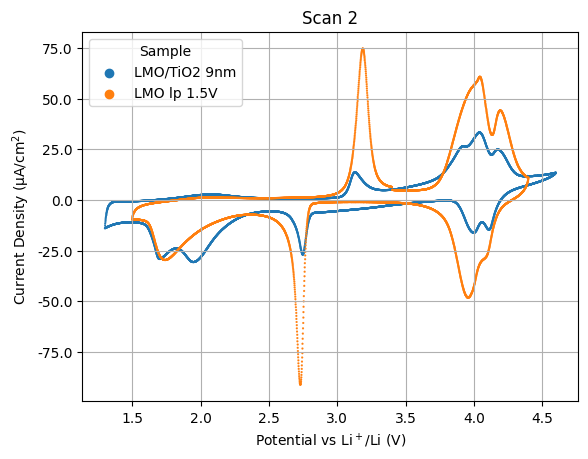

In [376]:
###### Comparison
scan = 2
old = df1[df1['Scan'] == 2]
old_tio2 = lmo_tio2_9[lmo_tio2_9['Scan'] == 2]
new = std02_lp[0][std02_lp[0]['Scan'] == scan]

a = pd.concat([old_tio2, new], ignore_index=True)

fig, ax = plt.subplots(dpi = 100)
ax.yaxis.set_major_formatter(formatter_1e6)
ax.set_ylabel(strings[1])
sns.scatterplot(data = a, x = col_cv[0], y = strings[0], hue = 'Sample', edgecolor = None, s = 2)
ax.grid()
plt.title(f'Scan {scan}')